In [1]:
import time
import logging
from abc import ABC
from abc import abstractmethod, abstractproperty
from typing import List

# import sympy as sp
# import numpy as np
import matplotlib.pyplot as plt
# import z3

# Learning and NN libraries
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F 
import torch.optim as optim

# Logging setup

In [2]:
root_logger = logging.getLogger('')
handler = logging.StreamHandler()
formatter = logging.Formatter(
  '%(asctime)s - %(module)-8s - %(levelname)-6s - %(message)s',
  datefmt='%Y-%m-%d %H:%M:%S' )
handler.setFormatter(formatter)
root_logger.addHandler(handler)

logger = logging.getLogger('logger')
logger.setLevel(logging.DEBUG)

# Training Certificate ($V$)

In [3]:
class Env(ABC):
  """Generic base class for all defined environments.

  *IMPORTANT*: All defined environments should inherit from this 
  class.
  """

  @abstractproperty
  def dim(self):
    """Number of dimensions of the environment."""
    ...

  @abstractproperty
  def bnd(self) -> (torch.Tensor, torch.Tensor):
    """Bounds of the environment."""
    ...

  @abstractproperty
  def tgt(self) -> (torch.Tensor, torch.Tensor):
    """Target space of the environment."""
    ...

  @abstractproperty
  def f(self, *args):
    """State transition function."""
    ...

  @property
  def device(self):
    if torch.cuda.is_available():
      return 'cuda'
    return 'cpu'

  @abstractproperty
  def sample_size(self):
    ...

In [10]:
class Spiral(Env):
  ALPHA, BETA = 0.5, 0.5
  """A simple 2-dimensional dynamical system with a spiral 
  trajectory."""

  dim = 2

  bnd = (
    torch.Tensor([-1.0, -1.0]),
    torch.Tensor([ 1.0,  1.0]),
  )

  init = bnd
    
  tgt = (
    torch.Tensor([-0.05, -0.05]),
    torch.Tensor([ 0.05,  0.05]),
  )

  def __init__(self, alpha: float = ALPHA, beta: float = BETA):
    self.alpha = alpha
    self.beta = beta

  def nxt(self, x: torch.Tensor):
    """The transition function f: X -> X."""
    a, b = self.alpha, self.beta
      
    x_nxt = torch.zeros_like(x)
    x_nxt[:, 0] = a*x[:, 0] + b*x[:, 1]
    x_nxt[:, 1] = -b*x[:, 0] + a*x[:, 1] 
    return x_nxt

  # Alias for nxt, for simpler notation
  f = nxt

  sample_size = int(1e6)

  def sample(self):
    """Returns a tuple of samples from different regions of the state
    space.

    Returns:
      (X_dec, ): X_dec are points sampled from the decrease
      (everywhere outside target) space.
    """
    N = 10
    X = [None for i in range(N)]
    x_init = torch.Tensor(1000, self.dim).uniform_(0., 1.)
    x_min, x_max = self.init
    for i in range(self.dim):
      x_init[:, i] = x_init[:, i] * (x_max[i] - x_min[i]) + x_min[i] 
    
    X[0] = x_init
    for i in range(1, N):
      X[i] = self.f(X[i - 1])

    S = torch.cat(X)
    return S

In [1232]:
class SuspendedPendulum(Env):
  """A simple 2-dimensional pendulum, suspended freely."""
  # G = gravitational acceleration, 
  # L = rod length, 
  # M = bob mass,
  # B = damping coefficient
  G, L, M, B = 9.8, 1, 1, 0.2
  TAU = 0.01
    # Sampling time delta
  dim = 2

  bnd = (
    # Bounds on the angular velocity are too pessimistic for now.
    torch.Tensor([-3.14, -8]), torch.Tensor([3.14, 8]),
  )

  init = (torch.Tensor([-1.57, 0.75]), torch.Tensor([1.57, 1]))

  tgt = (torch.
         Tensor([-0.05, -0.05]), torch.Tensor([0.05, 0.05]))

  def __init__(
      self,
      g: float = G,
      l: float = L,
      m: float = M,
      b: float = B):
    self.g = g
    self.l = l
    self.m = m
    self.b = b

  def nxt(self, x: torch.Tensor):
    """The transition function f: X -> X."""
    g, l, m, b = self.g, self.l, self.m, self.b
    tau = self.TAU

    x_nxt = torch.zeros_like(x)
    x_nxt[:, 0] = x[:, 0] + x[:, 1]*tau
    x_nxt[:, 1] = x[:, 1] + (
      -(b/m)*x[:, 1] - (g/l)*torch.sin(x[:, 0])
    )*tau
    return x_nxt

  # Alias for nxt, for simpler notation
  f = nxt

  sample_size = int(1e6)

  def sample(self):
    """Returns a tuple of samples from different regions of the state
    space.

    Returns:
      S: points sampled within the boundaries of the system, drawn
      from a normal distribution.
    """

    N = 100
    X = [None for i in range(N)]
    x_init = torch.Tensor(1, self.dim).uniform_(0., 1.)
    x_min, x_max = self.init
    for i in range(self.dim):
      x_init[:, i] = x_init[:, i] * (x_max[i] - x_min[i]) + x_min[i] 
    
    X[0] = x_init
    k = 2
    for i in range(1, N):
      X[i] = X[i-1]
      for _ in range(k):
        X[i] = self.f(X[i])

    S = torch.cat(X)
    return S

In [1254]:
def nn_A_2d():
  net = nn.Sequential(
    nn.Linear(2, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
  )

  return net 

def nn_V_2d():
  """Utility function to generate a default Reach certificate for a 
  2D space. Zeroing bias terms and using ReLU activation on the last 
  layer enforces Nonnegativity and Target conditions.
  """
  net = nn.Sequential(
    nn.Linear(2, 256, bias=True),
    nn.ReLU(),
    nn.Linear(256, 1, bias=False),
    nn.ReLU(),
  )

  return net


class Learner(ABC):
  @abstractmethod
  def __init__(self, env: Env, models: List[nn.Sequential]):
    ...

  @abstractmethod
  def fit(self, *args):
    ...

  @property
  def device(self):
    if torch.cuda.is_available():
      return 'cuda'
    return 'cpu'


class Learner_Reach_V(Learner):
  def __init__(self, env, models):
    # Assumption. Cert is a fully-connected NN with ReLU activation
    # after each hidden layer, as well as the output layer. We can
    # simply assume cert to be an instance of nn.Sequential,
    # initialized as follows:
    # nn.Sequential(
    #   nn.Linear(...),
    #   nn.ReLU(),
    #   ... )
    self.env = env
    self.V = models[0]

  def fit(self, S):
    """Fits V based on a predefined loss function.

    Args:
      S: a set of sampled points from the state space.
    """
    n_epoch = 16
    batch_size = 1000
    learning_rate = 1e-3

    self.V.to(self.device)
    S = S.to(self.device)

    optimizer = optim.SGD(
      self.V.parameters(),
      lr=learning_rate)

    dataloader = D.DataLoader(S, batch_size=batch_size, shuffle=True)
    for e in range(n_epoch + 1):
      for batch in dataloader:
        optimizer.zero_grad()
        loss = self.loss_fn(batch)
        loss.backward()
        nn.utils.clip_grad_norm_(self.V.parameters(), 1e2)
        optimizer.step()
      if e % (n_epoch >> 3) != 0:
        continue
      logger.debug(
        f'Epoch {e:>5}. '
        + f'Loss={self.loss_fn(S).item():>12.6f}, '
        + f'Chk={self.chk(S).item():>8.6f}, '
        + f'|S|={len(S):>8}, '
        + f'L.R.={learning_rate:.6f}'
      )

    torch.cuda.empty_cache()
    self.V.to('cpu')
    S = S.to('cpu')

    return S

  def loss_fn(self, S):
    """Aggregate loss function for the certificate NN. 

    New components can be added to the loss by defining new 
    functions and calling them in the expression evaluated below.
    """
    return 1e5 * self.loss_dec(S)

  def loss_dec(self, S, eps=0.1):
    """Loss component for the Decrease condition.

    For any point x in S, this functions increases the loss if
    V(f(x)) - V(x) + 1 > 0. This enforces that
    V(f(x)) < V(x) for all x in S.

    Args:
      S: a batch of points sampled from outside the target space.
    """
    S_nxt = self.env.f(S)
    return torch.mean(
        F.relu(self.V(S_nxt) - self.V(S) + eps)
    )

  def chk(self, S):
    S_nxt = self.env.f(S)
    return torch.max(torch.relu(self.V(S_nxt) - self.V(S) + 0.01))

## Using the `Spiral` environment

In [1304]:
env = Spiral(0.6, 0.7)
S = env.sample()
learner = Learner_Reach_V(env, [nn_V_2d()])
S = learner.fit(S)

2023-11-03 14:03:17 - 290303406 - DEBUG  - Epoch     0. Loss= 8907.011719, Chk=0.115556, |S|=   10000, L.R.=0.001000
2023-11-03 14:03:17 - 290303406 - DEBUG  - Epoch     2. Loss= 7387.424805, Chk=0.130853, |S|=   10000, L.R.=0.001000
2023-11-03 14:03:17 - 290303406 - DEBUG  - Epoch     4. Loss= 6735.711426, Chk=0.158552, |S|=   10000, L.R.=0.001000
2023-11-03 14:03:18 - 290303406 - DEBUG  - Epoch     6. Loss= 5868.776367, Chk=0.113572, |S|=   10000, L.R.=0.001000
2023-11-03 14:03:18 - 290303406 - DEBUG  - Epoch     8. Loss= 5266.223633, Chk=0.093257, |S|=   10000, L.R.=0.001000
2023-11-03 14:03:18 - 290303406 - DEBUG  - Epoch    10. Loss= 4676.156250, Chk=0.075165, |S|=   10000, L.R.=0.001000
2023-11-03 14:03:18 - 290303406 - DEBUG  - Epoch    12. Loss= 4045.880859, Chk=0.051589, |S|=   10000, L.R.=0.001000
2023-11-03 14:03:18 - 290303406 - DEBUG  - Epoch    14. Loss= 3537.423584, Chk=0.039649, |S|=   10000, L.R.=0.001000
2023-11-03 14:03:18 - 290303406 - DEBUG  - Epoch    16. Loss= 30

tensor(0.0497) tensor(-0.6749)
Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=False)
  (3): ReLU()
)


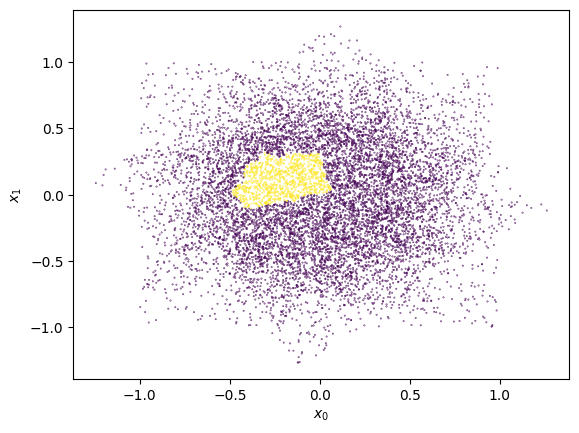

In [1268]:
x = S
x_nxt = env.f(x)
diff = learner.V(x_nxt) - learner.V(x)
diff = diff.detach()
print(torch.max(diff), torch.min(diff))
print(learner.V)

plt.scatter(S[:,0], S[:,1], s=0.1, c=torch.sign(diff))
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.show()

## Using the `SuspendedPendulum` environment

In [1330]:
env = SuspendedPendulum()
S = env.sample()
learner = Learner_Reach_V(env, [nn_V_2d()])
S = learner.fit(S)

2023-11-03 14:03:45 - 290303406 - DEBUG  - Epoch     0. Loss= 9989.285156, Chk=0.039359, |S|=     100, L.R.=0.001000
2023-11-03 14:03:45 - 290303406 - DEBUG  - Epoch     2. Loss= 9869.759766, Chk=0.070706, |S|=     100, L.R.=0.001000
2023-11-03 14:03:45 - 290303406 - DEBUG  - Epoch     4. Loss= 9526.770508, Chk=0.094115, |S|=     100, L.R.=0.001000
2023-11-03 14:03:45 - 290303406 - DEBUG  - Epoch     6. Loss= 9550.941406, Chk=0.093661, |S|=     100, L.R.=0.001000
2023-11-03 14:03:45 - 290303406 - DEBUG  - Epoch     8. Loss= 9278.052734, Chk=0.145171, |S|=     100, L.R.=0.001000
2023-11-03 14:03:45 - 290303406 - DEBUG  - Epoch    10. Loss= 9228.149414, Chk=0.140397, |S|=     100, L.R.=0.001000
2023-11-03 14:03:45 - 290303406 - DEBUG  - Epoch    12. Loss= 9142.707031, Chk=0.159133, |S|=     100, L.R.=0.001000
2023-11-03 14:03:45 - 290303406 - DEBUG  - Epoch    14. Loss= 9130.358398, Chk=0.161239, |S|=     100, L.R.=0.001000
2023-11-03 14:03:45 - 290303406 - DEBUG  - Epoch    16. Loss= 90

tensor(0.0552) tensor(-0.6896) tensor(-0.1234)
tensor([[-0.2794],
        [-0.0102],
        [-0.3503],
        [-0.3164],
        [-0.2831],
        [-0.1595],
        [-0.3053],
        [-0.2168],
        [-0.4207],
        [-0.3555]])
Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=False)
  (3): ReLU()
)


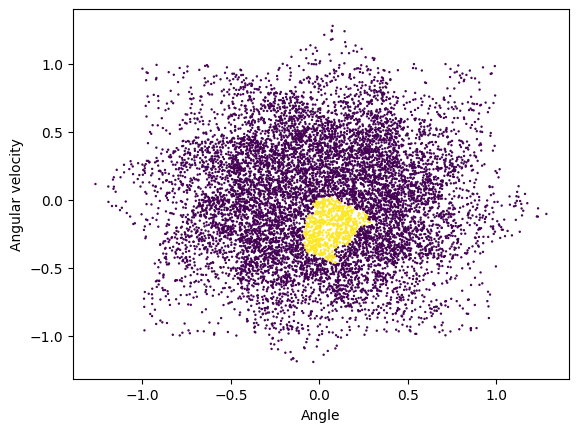

In [1305]:
x = S
x_nxt = env.f(x)
diff = learner.V(x_nxt) - learner.V(x)
diff = diff.detach()
print(torch.max(diff), torch.min(diff), torch.mean(diff))
print(diff[:10])
print(learner.V)

plt.scatter(S[:,0], S[:,1], s=0.5, c=torch.sign(diff))
plt.xlabel(r'Angle')
plt.ylabel(r'Angular velocity')
plt.show()

# Verification

## Using Z3

In [6]:
from z3 import *


# All the functions defined in this cell are re-definitions of 
# existing functions, but re-defined so that they can be used 
# in combination with an SMT solver (e.g., Z3).

def ReLU(x): return If(x >= 0 , x, 0)
def Abs (x): return If(x >= 0, x, -x)


def V(x):
    ReLU_ = np.vectorize(ReLU)
    y1 = w1 @ x + b1
    z1 = ReLU_(y1)
    y2 = w2 @ z1 + b2
    z2 = ReLU_(y2)
    y3 = w3 @ z2 + b3
    z3 = ReLU_(y3)
    return y3


def F(x):
    a, b = env.alpha, env.beta
    A = np.array( [
      [ a,  b], 
      [-b,  a]
    ] )
    return A @ x


def cex(C, x):
    """List of counter-examples to C.
    
    Args:
      C: A list of Z3 constraints.
    """
    s = Solver()
    s.add(C)
    chk = s.check()
    # print(f'CEX. chk={chk}')
    if chk == sat:
        m = s.model()
        n = len(x)
        return [ float(m[x[i]].as_fraction()) for i in range(n) ]
    elif chk == unsat:
        return None
    else:
        assert False, 'unknown result for SMT query'


def chk_dec(x):
    """Verification task for the Decrease condition."""
    # print('CHK_DEC. Setting up the problem ...')
    domain = []
    domain += [Abs(x[i]) >= 0.05 for i in range(2)]
    domain += [Abs(x[i]) <= 1.00 for i in range(2)]
    
    problem = []
    V_x = V(x)
    VF_x = V(F(x))
    problem.append(v  == V_x [0])
    problem.append(vf == VF_x[0])
    problem.append(v - vf < EPS_DEC)

    return cex(domain + problem, x)


def chk_tgt(x):
    """Verification task for the Target condition."""
    # print('CHK_TGT. Setting up the problem ...')
    domain = [Abs(x[i]) <= 0.05 for i in range(2)]
    problem = []
    V_x = V(x)
    problem.append(v == V_x[0])
    problem.append(v  > EPS_TGT)
    
    return cex(domain + problem, x)

# CEGIS Loop

In [12]:
MAX_CEGIS_ITER = 10
MAX_TRAIN_ITER = 10

env = Spiral(alpha=0.6, beta=0.7)
X = torch.rand(10000, 2)*2 - 1
tgt_mask = torch.logical_and(
    torch.abs(X[:,0]) <= 0.05,
    torch.abs(X[:,1]) <= 0.05, )
X_tgt = torch.rand(500, 2)*0.1 - 0.05
X_dec = X[~tgt_mask]

for i in range(MAX_CEGIS_ITER):
    print(f'CEGIS. Iter. {i:>2}')
    print(f'CEGIS. |X_tgt|={len(X_tgt)}, |X_dec|={len(X_dec)}')
    cert = None
    for i in range(MAX_TRAIN_ITER):
        # print(f'CEGIS. Train iter. {i:>2}')
        cert = reach_nn()
        fit_cert(cert, X_tgt, X_dec)
        if chk_train(cert, X_tgt, X_dec): 
            print(f'CEGIS. Cert found on iter. {i}')
            break
    if not cert:
        raise RuntimeError('Target or Decrease condition failed.')
    
    x = np.array(RealVector('x', 2))
    w1, w2, w3 = [
        cert.layers[i].weight.data.numpy() for i in range(3)]
    b1, b2, b3 = [
        cert.layers[i].  bias.data.numpy() for i in range(3)]
    v, vf = Real('v'), Real('vf')
    cex_tgt = chk_tgt(x)
    cex_dec = chk_dec(x)
    print(f'CEGIS. CEx-s. Tgt={cex_tgt}, Dec={cex_dec}')
    if cex_tgt:
        assert not chk_tgt_train(cert, torch.Tensor([cex_tgt]))
        X_tgt = torch.vstack([X_tgt, torch.Tensor(cex_tgt)])
    if cex_dec: 
        assert not chk_dec_train(cert, torch.Tensor([cex_dec]))
        X_dec = torch.vstack([X_dec, torch.Tensor(cex_dec)])
    if not cex_tgt and not cex_dec:
        print('CEGIS. Cert found.')
        break

CEGIS. Iter.  0
CEGIS. |X_tgt|=500, |X_dec|=9980
CEGIS. Cert found on iter. 2
CEGIS. CEx-s. Tgt=None, Dec=[0.05, 0.05]
CEGIS. Iter.  1
CEGIS. |X_tgt|=500, |X_dec|=9981
CEGIS. CEx-s. Tgt=None, Dec=[0.08346257346446541, 0.05]
CEGIS. Iter.  2
CEGIS. |X_tgt|=500, |X_dec|=9982
CEGIS. Cert found on iter. 2
CEGIS. CEx-s. Tgt=[0.05, 0.049488427521883774], Dec=None
CEGIS. Iter.  3
CEGIS. |X_tgt|=501, |X_dec|=9982
CEGIS. Cert found on iter. 0
CEGIS. CEx-s. Tgt=None, Dec=[0.07492178212062038, -0.05]
CEGIS. Iter.  4
CEGIS. |X_tgt|=501, |X_dec|=9983
CEGIS. Cert found on iter. 1
CEGIS. CEx-s. Tgt=None, Dec=None
CEGIS. Cert found.


# Training Abstraction, Bound, and Certificate ($A$, $B$, $V$)

In [37]:
# N_EPOCH, N_BATCH = 2048, 50
N_EPOCH, N_BATCH = 256, 50  # For debugging purposes
LR, WEIGHT_DECAY = 1e-3, 1e-5

A = nn_abst_2d()
B = nn_bound_2d()
V = nn_cert_2d()


# env = Spiral(alpha=0.7, beta=0.6)
env = SuspendedPendulum()
S = env.sample()


def loss_fn(A, B, V, ball, S):
    # Abst and bound are very inter-related, so loss of either of them
    # depends on the other as well.
    return (
        loss_abst(A, B, S)
        # + loss_bound(B, S)
        + loss_cert(A, B, V, ball, S)
    )


def loss_abst(A, B, S):
    f_vec = torch.vmap(env.f)
    # diff = || abst(X) - f(X) ||. Diff should be casted into a 2D Tensor with 
    # dimensions Nx1.
    err = torch.norm(A(S) - f_vec(S), dim=1, p=1)
    err = torch.unsqueeze(err, dim=1)
    return torch.mean( torch.relu(err - B(S)) )


def loss_bound(B, S):
    return torch.mean(B(X))


def loss_cert(A, B, V, ball, S):
    def loss_cert_state(s):
        return torch.sum(
            torch.relu(V(A(s) + B(s)*ball) - V(s) + 1) )
    l_vec = torch.vmap(loss_cert_state)
    return torch.mean(l_vec(S))


ball = sample_ball(2, 10)
loss_cert(A, B, V, ball, S)
state_ld = D.DataLoader(
    S, batch_size= len(S) // N_BATCH, shuffle=True)


optimizer = optim.Adam(
    list(A.parameters()) + list(B.parameters()) + list(V.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

for e in range(N_EPOCH+1): 
    epoch_loss = 0
    ball = sample_ball(2, 100)
    state_it = iter(state_ld)
    for b in range(N_BATCH):
        states = next(state_it)
        optimizer.zero_grad()
        loss = loss_fn(A, B, V, ball, states)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    if e % (N_EPOCH >> 4) == 0:
        print(f'-- FIT_CERT. Epoch {e:>5}. Loss={epoch_loss/N_BATCH:>16.6f}')

print('Loss_abst(A, B, S)=', loss_abst(A, B, S).item())
print('Loss_cert(A, B, V, ball, S)=', loss_cert(A, B, V, ball, S).item())

-- FIT_CERT. Epoch     0. Loss=       17.287419
-- FIT_CERT. Epoch    16. Loss=        1.709638
-- FIT_CERT. Epoch    32. Loss=        0.982979
-- FIT_CERT. Epoch    48. Loss=        0.604551
-- FIT_CERT. Epoch    64. Loss=        0.415672
-- FIT_CERT. Epoch    80. Loss=        0.486285
-- FIT_CERT. Epoch    96. Loss=        0.320079
-- FIT_CERT. Epoch   112. Loss=        0.376186
-- FIT_CERT. Epoch   128. Loss=        0.202020
-- FIT_CERT. Epoch   144. Loss=        0.230842
-- FIT_CERT. Epoch   160. Loss=        0.167787
-- FIT_CERT. Epoch   176. Loss=        0.124017
-- FIT_CERT. Epoch   192. Loss=        0.221875
-- FIT_CERT. Epoch   208. Loss=        0.803113
-- FIT_CERT. Epoch   224. Loss=        0.552958
-- FIT_CERT. Epoch   240. Loss=        0.149354
-- FIT_CERT. Epoch   256. Loss=        0.104759
Loss_abst(A, B, S)= 0.11586848646402359
Loss_cert(A, B, V, ball, S)= 0.0021768808364868164


## Visualizing $V(S)$, $V(A(S))$, $B(S)$

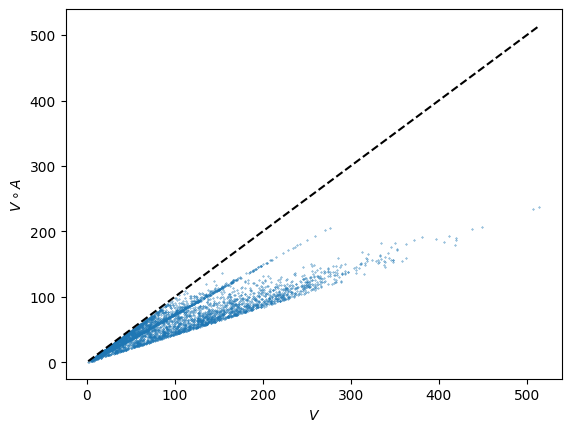

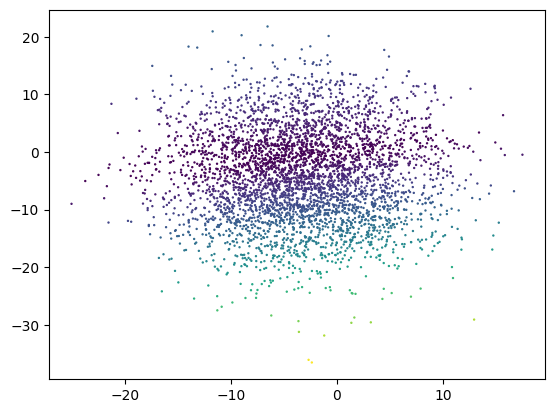

In [21]:
v  = V(S)
vf = V(A(S))
v, vf = v.detach(), vf.detach()

plt.plot(
    [torch.min(v), torch.max(v)], [torch.min(v), torch.max(v)], 'k--')
plt.scatter(v, vf, s=0.1)
plt.xlabel(r'$V$')
plt.ylabel(r'$V \circ A$')
plt.show()

plt.scatter(S[:,0], S[:,1], s=0.5, c=B(S).detach())
plt.show()

# Verification

## Using DReal

In [4]:
import dreal
import sympy as sp


def sympy_to_dreal(expr, var):
  """Translate SymPy expression to DReal.

  Args:
    expr: SymPy expression.
    var: a dictionary mapping SymPy Symbols to their DReal ebquivalents. 
  """
  if isinstance(expr, sp.Symbol):
    return var[expr]
  if isinstance(expr, sp.Number):
    return expr
  if isinstance(expr, sp.Add):
    acc = sympy_to_dreal(expr.args[0], var)
    for arg in expr.args[1:]:
      acc += sympy_to_dreal(arg, var)
    return acc
  if isinstance(expr, sp.Mul):
    acc = sympy_to_dreal(expr.args[0], var)
    for arg in expr.args[1:]:
      acc *= sympy_to_dreal(arg, var)
    return acc
  if isinstance(expr, sp.And):
    args = [sympy_to_dreal(arg, var) for arg in expr.args]
    return dreal.And(*args)
  if isinstance(expr, sp.Or):
    args = [sympy_to_dreal(arg, var) for arg in expr.args]
    return dreal.Or(*args)
  if isinstance(expr, sp.GreaterThan):
    l, r = [sympy_to_dreal(arg, var) for arg in expr.args]
    return l >= r
  if isinstance(expr, sp.LessThan):
    l, r = [sympy_to_dreal(arg, var) for arg in expr.args]
    return l <= r
  if isinstance(expr, sp.StrictGreaterThan):
    l, r = [sympy_to_dreal(arg, var) for arg in expr.args]
    return l > r
  if isinstance(expr, sp.StrictLessThan):
    l, r = [sympy_to_dreal(arg, var) for arg in expr.args]
    return l < r
  # Functions 
  if isinstance(expr, sp.Abs):
    arg = sympy_to_dreal(expr.args[0], var)
    return dreal.if_then_else(arg > 0, arg, 0)
  if isinstance(expr, sp.sin):
      arg = sympy_to_dreal(expr.args[0], var)
      return dreal.sin(arg)
  if isinstance(expr, sp.cos):
    arg = sympy_to_dreal(expr.args[0], var)
    return dreal.cos(arg)
  if isinstance(expr, sp.exp):
    arg = sympy_to_dreal(expr.arg[0], var)
    return dreal.exp(arg)
  if isinstance(expr, sp.Function) and expr.name == 'ReLU':
    arg = sympy_to_dreal(expr.args[0], var)
    return dreal.if_then_else(arg < 0, 0, arg)
  raise NotImplementedError(type(expr))

In [39]:
diff = Net(A, X(2)) - F_SuspendedPendulum(X(2))
norm1 = sp.Abs(diff[0]) + sp.Abs(diff[1])

b = Net(B, X(2))
assert b.shape == (1, 1)
b = b[0]

x_sp = X(2)
x_dr = [dreal.Variable(f'x_{i}') for i in range(2)]
vars = {x_sp[i]: x_dr[i] for i in range(2)}
formula = sympy_to_dreal(norm1 > b, vars)
bounds = sympy_to_dreal(BoundIn(env.bnd, X(2)), vars)
formula = dreal.And(formula, bounds)
dreal.CheckSatisfiability(formula, 0.001)

<Box "x_0 : [-0.010419033279253663, -0.010213865943867823]
x_1 : [6.0894006339653082, 6.0898005658924461]">

## NN Composition, Exporting with ONNX

In [22]:
class NormL1Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4, bias=False)
        self.fc2 = nn.Linear(4, 1, bias=False)
        with torch.no_grad():
            self.fc1.weight = nn.Parameter(
                torch.hstack([torch.eye(2, 2), torch.eye(2, 2) * -1]).T )
            self.fc2.weight = nn.Parameter(torch.ones(1, 4))
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


class SumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 2, bias=False)
        with torch.no_grad():
            self.fc1.weight = nn.Parameter(
                torch.vstack([torch.eye(2, 2), torch.eye(2, 2)]).T )

    def forward(self, x, y): 
        xy = torch.cat((x, y), dim=-1)
        xy = self.fc1(xy)
        return xy


print ('norml1([-1,2])=', NormL1Net()(torch.Tensor([-1, 2])))
print('sum_([1,2], [3,4])=', 
      SumNet()(torch.Tensor([1, 2]), torch.Tensor([3, 4]))
     )


class ABV(nn.Module):
    def __init__(self, A, B, V):
        super().__init__()
        self.A = A
        self.B = B
        self.V = V
        self.NormL1 = NormL1Net()
        # self.Sum = SumNet()
    
    def forward(self, x, y):
        v = self.V(x)
        xp = self.A(x) + y
        vp = V(xp)
        norm_y = self.NormL1(y)
        b = B(x)
        return torch.cat([norm_y + -1*b, v + -1*vp], dim=-1)


abv = ABV(A, B, V)
x, y = torch.randn(1, 2), torch.randn(1, 2)
o = abv(x, y)
torch.onnx.export(abv, (x, y), 'abv.onnx', input_names=['x', 'y'], output_names=['o'])

model = onnx.load("abv.onnx")

# Check that the model is well formed
onnx.checker.check_model(model)

ort_session = ort.InferenceSession("abv.onnx")

o1 = ort_session.run(
    None,
    { 'x': x.numpy(),
      'y': y.numpy(), }
)

print(o.detach().numpy(), o1,)

norml1([-1,2])= tensor([3.], grad_fn=<SqueezeBackward4>)
sum_([1,2], [3,4])= tensor([4., 6.], grad_fn=<SqueezeBackward4>)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[[ 2.5665944 -4.3131094]] [array([[ 2.5665944, -4.3131084]], dtype=float32)]


## Using Marabou

In [30]:
from maraboupy import Marabou

network = Marabou.read_onnx('abv.onnx')

x, y = network.inputVars[0][0], network.inputVars[1][0]
o = network.outputVars[0][0]
print(f'x = {x}')
print(f'y = {y}')
print(f'o = {o}')

network.setLowerBound(x[0], -3.15)
network.setUpperBound(x[0], 3.15)
network.setLowerBound(x[1], -8.0)
network.setUpperBound(x[1], 8.0)

network.setUpperBound(o[0], 0.0)
network.setUpperBound(o[1], 0.0)

options = Marabou.createOptions(verbosity=0, tighteningStrategy='sbt')
result = network.solve(options=options)
print(f'result[0]={result[0]}')
print(f'result[1]={result[1]}')
print(f'result[2]={result[2]}')

x = [0 1]
y = [2 3]
o = [4 5]
sat
input 0 = -7.585608690518937e-16
input 1 = -4.2575031128513607e-16
input 0 = 1.6020993680355075e-16
input 1 = 5.361359916123343e-18
output 0 = 0.0
output 1 = -0.5385425110067796
result[0]=sat
result[1]={0: -7.585608690518937e-16, 1: -4.2575031128513607e-16, 2: 1.6020993680355075e-16, 3: 5.361359916123343e-18, 4: 0.0, 5: -0.5385425110067796, 6: 1.8041124150158794e-16, 7: -3.469446951953614e-18, 8: -2.1509510184903798e-16, 9: -4.431404338150504e-17, 10: 0.0, 11: 0.0, 12: -0.0, 13: 1.3401807607978806e-16, 14: 0.0, 15: 0.017488410696387145, 16: -0.4439630806446076, 17: -0.6334491372108458, 18: -0.16246117651462544, 19: -0.9357950687408447, 20: 0.048185907304287075, 21: -0.12886509299278281, 22: -0.06037531048059448, 23: -0.776094377040863, 24: -0.41106989979743924, 25: 0.49288824200630166, 26: 0.007099097128957289, 27: -0.4180326759815223, 28: 0.031004119664430292, 29: 0.025013159960508125, 30: 0.0028468451928343316, 31: 0.01748841069638731, 32: 0.0, 33: 0

In [32]:
torch.randn(10, 2) + torch.Tensor([1, 2])

tensor([[-8.7667e-04,  9.7817e-01],
        [-1.0344e+00,  3.1451e+00],
        [ 1.1141e-01,  2.1156e+00],
        [ 1.3428e+00,  2.9881e+00],
        [-2.0032e+00,  2.2454e+00],
        [ 1.5730e+00,  2.7223e+00],
        [ 1.2265e+00,  2.4351e+00],
        [ 1.6644e+00,  1.7113e+00],
        [ 2.3044e+00,  2.4500e+00],
        [ 1.1459e-01,  3.3927e+00]])

## MarabouPy ONNX Example (from the Docs)

In [4]:
from maraboupy import Marabou

options = Marabou.createOptions(verbosity = 0)

print("Fully Connected Network Example")
filename = "../Marabou/resources/onnx/fc1.onnx"
network = Marabou.read_onnx(filename)

inputName = 'Placeholder:0'
outputName = 'y_out:0'
network = Marabou.read_onnx(filename=filename, inputNames=[inputName], outputNames = outputName,)

inputVars = network.inputVars[0][0]
outputVars = network.outputVars[0][0]

print('inputVars=', inputVars)
print('outputVars=', outputVars)


network.setLowerBound(inputVars[0],-10.0)
network.setUpperBound(inputVars[0], 10.0)
network.setLowerBound(inputVars[1],-10.0)
network.setUpperBound(inputVars[1], 10.0)

network.setLowerBound(outputVars[1], 194.0)
network.setUpperBound(outputVars[1], 210.0)

result = network.solve(options = options)
# print(result)

Fully Connected Network Example
inputVars= [0 1]
outputVars= [2 3]
sat
input 0 = -9.718171719756969
input 1 = 10.0
output 0 = 19.573110796205448
output 1 = 194.0


## Using PySMT

In [142]:
from pysmt.shortcuts import (
    Symbol, Real, Int,
    And, Not, Ite,
    LE, GE, LT, GT,
    Plus, Times, Equals,
    is_sat, get_model
)
from pysmt.typing import INT, REAL

def ReLU(x):
    return Ite(LT(x, Int(0)), Int(0), x)

def test():
    x = Symbol('xi', INT)
    y = Symbol('yi', INT)
    
    formula = ReLU(x) + ReLU(y)
    formula = Equals(formula, Int(5))
    formula = And(formula, GT(x, Int(0)))
    print(formula)
    
    model = get_model(formula, solver_name='msat')
    print(model[x], model[y])    

test()

(((((... < ...) ? 0 : xi) + ((... < ...) ? 0 : yi)) = 5) & (0 < xi))
5 0


## Using CVC5

In [156]:
import cvc5.pythonic as cvc

def ReLU(x):
    return cvc.If(x < 0, 0, x)

x, y = cvc.Ints('x y')
s = cvc.Solver()
s.add(ReLU(x) + ReLU(y) == 5)
s.add(x > 0)
if s.check() == cvc.sat:
    print(s.model())

[x = 1, y = 4]


## SymPy translations, revisited

In [92]:
ReLU = sp.Function('ReLU')


def Net(net: nn.Sequential, x: sp.Matrix):
    """Representation of a ReLU-activated NN in SymPy.
  
    Args:
    net: an instance of nn.Sequential. We assume all layers are 
    instances of either nn.Linear (fully connected feed-forward) or 
    nn.ReLU (activation functions).
    x: input matrix.
    """
    constraints = []
    for i in range(len(net)):
        layer = net[i]
        match layer:
            case nn.Linear():
                y = sp.Matrix([f'y_{i}_{j}' for j in range(layer.out_features)])
                W = net[i].weight.data.numpy()
                b = net[i].bias.data.numpy()
                b = np.expand_dims(b, 1)
                out = W @ x + b
                for j in range(layer.out_features):
                    constraints.append(sp.Eq(y[j], out[j]))
                x = y
            case nn.ReLU():
                y = sp.Matrix([f'y_{i}_{j}' for j in range(len(x))])
                for j in range(len(x)):
                    constraints.append(sp.Eq(y[j], ReLU(x[j])))
                x = y
    return constraints


net = nn.Sequential(
    nn.Linear(2, 3),
    nn.ReLU()
)

with torch.no_grad():
    net[0].bias = nn.Parameter(torch.zeros_like(net[0].bias))


print (Net(net, X(2)))

[Eq(y_0_0, -0.660464*x_0 - 0.702482*x_1), Eq(y_0_1, -0.493113*x_0 + 0.456284*x_1), Eq(y_0_2, -0.0123601*x_0 - 0.63435*x_1), Eq(y_1_0, ReLU(y_0_0)), Eq(y_1_1, ReLU(y_0_1)), Eq(y_1_2, ReLU(y_0_2))]


In [125]:
z3.Real(str(sp.Symbol('B(1, 2)')))

B(1, 2)

# Recycle Bin

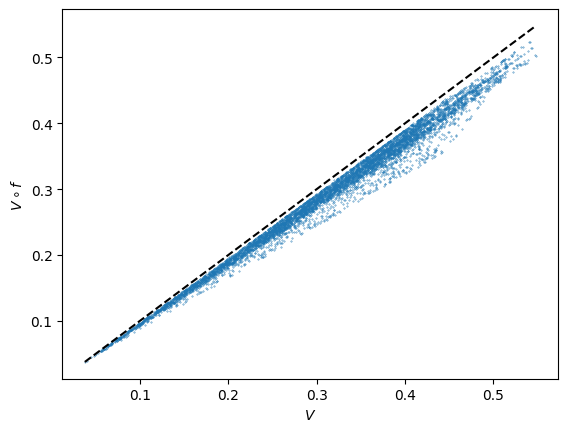

In [5]:
v  = cert(x)
vf = cert(torch.vmap(env.f)(x))
v, vf = v.detach(), vf.detach()

plt.plot(
    [torch.min(v), torch.max(v)], [torch.min(v), torch.max(v)], 'k--')
plt.scatter(v, vf, s=0.1)
plt.xlabel(r'$V$')
plt.ylabel(r'$V \circ f$')
plt.show()

v = cert(x_dec)
vf = cert(torch.vmap(env.f)(x_dec))
assert torch.all(v > vf), 'Decrease condition negated on training data'

# Partitioning

## Heuristic: Strengthened Decrease Condition

In [16]:
def partition(x, y):
    N = len(x)
    P = []
    
    for i in range(N):
        print(f'i={i}. P={P}')
        # idx is the lowest value where v(f(x[i])) < v[x[idx]]
        _, idx = binary_search(
            P, len(P), lambda p: y[i] >= p[0][0])
        print(f'  idx={idx}')
        if idx == len(P):
            P.append( [(x[i], y[i])] )
        else:
            P[idx].append( (x[i], y[i]) )
    return x, P

x = [2,   3, 4,   5,    6, 7]
y = [1, 1.5, 3, 1.75, 3.5, 5]

x, P = partition(x, y)
print(f'P={P}')

i=0. P=[]
  idx=0
i=1. P=[[(2, 1)]]
  idx=0
i=2. P=[[(2, 1), (3, 1.5)]]
  idx=1
i=3. P=[[(2, 1), (3, 1.5)], [(4, 3)]]
  idx=0
i=4. P=[[(2, 1), (3, 1.5), (5, 1.75)], [(4, 3)]]
  idx=1
i=5. P=[[(2, 1), (3, 1.5), (5, 1.75)], [(4, 3), (6, 3.5)]]
  idx=2
P=[[(2, 1), (3, 1.5), (5, 1.75)], [(4, 3), (6, 3.5)], [(7, 5)]]


In [136]:
def binary_search(a, n, f):
    """Binary search with a given condition f.
    
    Returns: 
      l: highest value for i where f[i] holds.
      r: lowest  value for i where f[i] does not hold.
    """
    l, r = -1, n
    while r-l > 1:
        m = (l+r) >> 1
        if f(a[m]):
            l = m
        else:
            r = m
    return l, r


def partition(x: torch.Tensor, v, f):
    # Assumption. The learned certificate does not violate the 
    # decrease condition on any of the states given in x.
    f_vmap = torch.vmap(f)
    assert torch.all(v(x) > v(f_vmap(x)))
    
    _, sort_idx = torch.sort(v(x), dim=0)
    # Sort x such that (i < j) <=> v(x[i]) < v(x[j])
    x = x[sort_idx]
    # Remove extra dimensions of size 1 that come from 
    # picking certain indices of x.
    # After this step, x should be a Nx2 matrix.
    x = torch.squeeze(x)
    
    # A list of all partitions.
    # For each partition p, p[0] is the _representative_ of p.
    # This property of the partitions enables us to use binary 
    # search when choosing an existing partition for a new point.
    P = []
    for i in range(len(x)):
        # idx is the first existing partition to which we can 
        # add x[i].
        _, idx = binary_search(
            P, len(P), lambda p: v(f(x[i])) >= v(p[0]))
        if idx == len(P): 
            # x[i] cannot be added to any of the existing partitions,
            # so we need to create its own partition.
            P.append( [x[i]] )
        else:
            P[idx].append(x[i])
    return x, P


_, P = partition(x_dec, cert, env.f)
print(f'|P|={len(P)}')

|P|=67


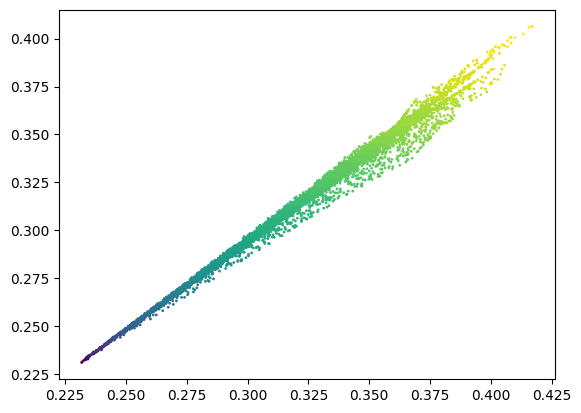

In [137]:
f_vec = torch.vmap(env.f)

x_dec1, v, vf, c = [], [], [], []
for i, p in enumerate(P):
    x_p = torch.vstack(p)
    x_dec1.append(x_p)
    v.append(cert(x_p).detach())
    vf.append(cert(f_vec(x_p)).detach())
    c.append(torch.ones(len(x_p))*i)

x_dec1 = torch.vstack(x_dec1)
v = torch.vstack(v)
vf = torch.vstack(vf)
c = torch.cat(c)

plt.scatter(v, vf, c=c, s=1)
plt.show()

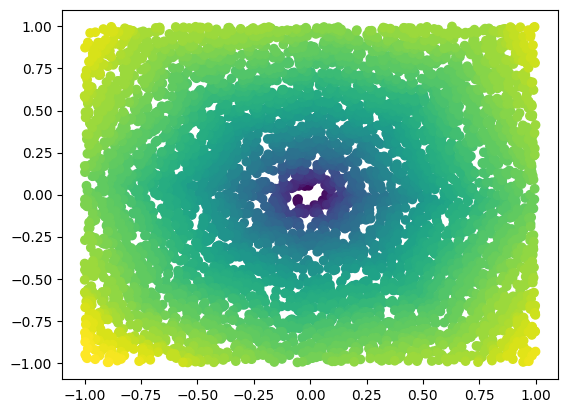

In [138]:
plt.scatter(x_dec1[:,0], x_dec1[:,1],c=c)
plt.show()

In [139]:
SZ_P = len(P)
part = nn.Sequential(
    nn.Linear(2, 2*SZ_P), nn.ReLU(),
    nn.Linear(2*SZ_P, SZ_P), nn.ReLU(),
)

ids, cnt = torch.unique(c, return_counts=True)
# Similar to sklearn.utils.class_weight.compute_class_weight
weight = len(x_dec1) / (SZ_P * cnt)
loss_fn = nn.CrossEntropyLoss(weight=weight)

optimizer = optim.Adam(part.parameters(), lr=1e-3, weight_decay=1e-5)

N_EPOCH, BATSZ = 1024, 100
N_BATCH = len(x_dec1) // BATSZ
print(f'BATSZ={BATSZ}')
c = c.long()
dataset = D.TensorDataset(x_dec1, c)
bat_ld = D.DataLoader(
    dataset, 
    batch_size=BATSZ, 
    shuffle=True)

for e in range(N_EPOCH+1):
    epoch_loss = 0
    bat_it = iter(bat_ld)
    for b in range(N_BATCH):
        optimizer.zero_grad()
        nxt_bat = next(bat_it)
        x_d, y = nxt_bat
        loss = loss_fn(part(x_d), y)
        epoch_loss += loss.data
        loss.backward()
        optimizer.step()
        
    if e % 128 == 0:
        print(f'{e:>4}. Loss={epoch_loss:>16.6f}')

BATSZ=100
   0. Loss=      263.677246
 128. Loss=      225.069580
 256. Loss=      218.479980
 384. Loss=      212.862717
 512. Loss=      208.519791
 640. Loss=      206.038513
 768. Loss=      204.224548
 896. Loss=      199.853928
1024. Loss=      192.275497


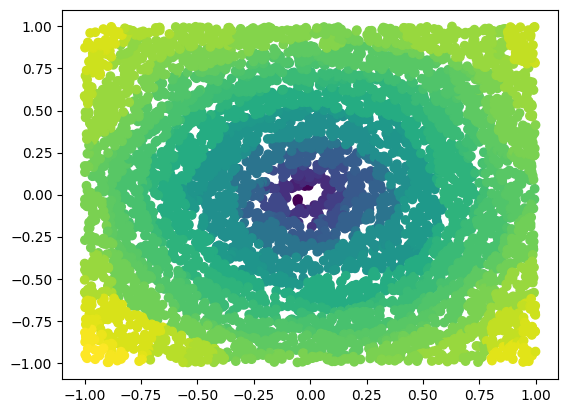

In [140]:
c_part = torch.argmax(part(x_dec1), dim=1)
plt.scatter(x_dec1[:,0], x_dec1[:,1], c=c_part)
plt.show()

In [141]:
print(classification_report(c, c_part))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.43      1.00      0.60         3
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         2
           7       0.50      0.44      0.47         9
           8       0.00      0.00      0.00         6
           9       0.35      0.67      0.46        12
          10       0.29      0.46      0.35        13
          11       0.29      0.60      0.39        10
          12       0.00      0.00      0.00        11
          13       0.30      0.55      0.39        11
          14       0.00      0.00      0.00         9
          15       0.29      0.45      0.35        20
          16       0.25      0.91      0.39        11
          17       0.00    

/Users/mahyar/anaconda3/envs/prototype/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mahyar/anaconda3/envs/prototype/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mahyar/anaconda3/envs/prototype/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## Heuristic: $U(\mathbf{x}) = V(\mathbf{x}) - V(f(\mathbf{x}))$, Clustering

In [183]:
def knee(crv: torch.Tensor):
    """Knee point of a 2D-curve [(x1, y1), ..., (xn, yn)].
    
    We define the knee point of this curve as the point (xi, yi)
    which is the point farthest away from the line connecting 
    (x1, y1) and (xn, yn) (i.e., the line that connects the first 
    and last points in the curve).
    """
    assert len(crv.shape) == 2 and crv.shape[1] == 2
    
    # h = 2A / b
    b = (crv[0] - crv[-1]).square().sum().sqrt()
    # print(f'b={b}')

    x1, y1 = crv[0]
    xn, yn = crv[-1]
    idx_knee, h_knee = 0, 0.0
    for i, (xi, yi) in enumerate(crv):
        h = torch.abs((xn - x1)*(y1 - yi) - (yn - y1)*(x1 - xi)) / b
        # print(f'i={i:>2}, h[{i}]={h:>8.6f}')
        if h < h_knee:
            continue
        idx_knee, h_knee = i, h
    return idx_knee


curve = torch.Tensor([
    [0, 0],
    [1, 1],
    [2, 3],
    [3, 2],
    [4, 1],
    [5, 0],
])

assert knee(curve) == 2

Knee. k=8


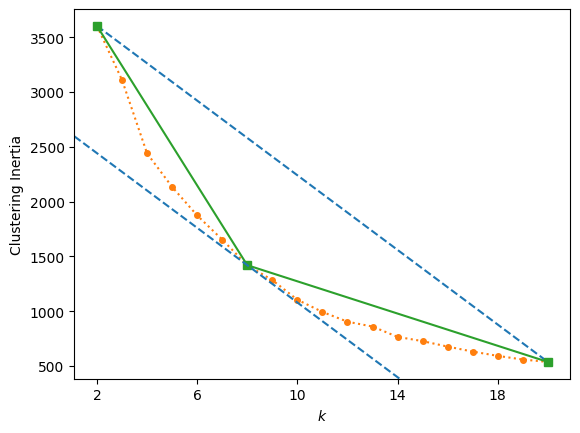

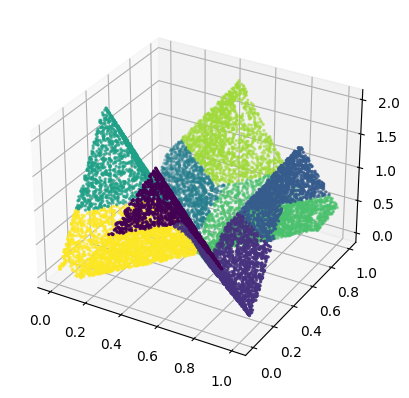

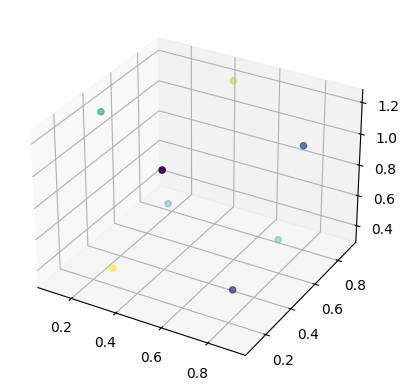

In [236]:
f_vec = torch.vmap(env.f)
dec = cert(x) - cert(f_vec(x))
p = torch.hstack(
    (x, dec.detach())
)

# Dimension normalization 
p_min, p_max = p.min(dim=0).values, p.max(dim=0).values
p = (p - p_min) / (p_max - p_min)
p[:, -1] *= 2
# p[:, -1] += 1000

curve = []
for k in range(2,20+1):
    kmeans = KMeans(n_clusters=k, n_init='auto').fit(p)
    curve.append( (k, kmeans.inertia_) )
curve = torch.Tensor(curve)

k = knee(curve)
print(f'Knee. k={2+k}')

plt.figure()
x1, y1 = curve[0]
xn, yn = curve[-1]
plt.plot([x1, xn], [y1, yn], '--')
plt.plot(curve[:,0], curve[:,1], ':o', markersize=4)
xk, yk = curve[k]
plt.plot([x1, xk, xn], [y1, yk, yn], '-s')
plt.xticks(range(2,21,4))
plt.axline((xk, yk), slope=(y1-yn)/(x1-xn), linestyle='dashed')
plt.xlabel(r'$k$')
plt.ylabel('Clustering Inertia')

kmeans = KMeans(n_clusters=2+k, n_init='auto').fit(p)
# p[:,-1] /= 2
## p[:,-1] -= 1000
# p = p * (p_max - p_min) + p_min
cs = kmeans.cluster_centers_

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(p[:,0], p[:,1], p[:,2], c=kmeans.labels_, s=2)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cs[:,0], cs[:,1], cs[:,2], c=range(2+k))
plt.show()

In [4]:
env  = Spiral(alpha=0.6, beta=0.7)
cert = reach_nn()  # Certificate NN.

x = torch.rand(6400, 2)*2 - 1
tgt_mask = torch.logical_and(
    torch.abs(x[:,0]) <= 0.05,
    torch.abs(x[:,1]) <= 0.05, )
x_tgt = torch.rand(400, 2)*0.1 - 0.05
x_dec = x[~tgt_mask]
print(f'|x_tgt|={len(x_tgt)}, |x_dec|={len(x_dec)}')

fit_cert(cert, x_tgt, x_dec)

|x_tgt|=400, |x_dec|=6387


# Translator with SymPy

In [32]:
import sympy as sp


cert = reach_nn()
x = sp.Matrix([f'x_{i}' for i in range(2)])
W0, b0 = cert[0].weight, cert[0].bias
W0, b0 = W0.data, b0.data
ReLU = sp.Function('ReLU')
fx = (W0 * x + b0[:, None]).applyfunc(ReLU)
fx = fx[0]

def sympytoz3(expr, var):
    if isinstance(expr, sp.Symbol):
        return var[expr]

    if isinstance(expr, sp.Add):
        acc = sympytoz3(expr.args[0], var)
        for arg in expr.args[1:]:
            acc += sympytoz3(arg, var)
        return acc
    if isinstance(expr, sp.Float):
        return z3.RealVal(float(expr))
    if isinstance(expr, sp.Mul):
        acc = sympytoz3(expr.args[0], var)
        for arg in expr.args[1:]:
            acc *= sympytoz3(arg, var)
        return acc
    if isinstance(expr, sp.Function) and expr.name == 'ReLU':
        arg = sympytoz3(expr.args[0], var)
        return z3.If(arg > 0, arg, 0)

x_z3 = {x[0]: z3.Real('x'), x[1]: z3.Real('y')}
print('sympy2z3(fx)=', sympy_to_z3(fx, x_z3))
print('fx=', fx)

sympy2z3(fx)= If(1406075119972229/2000000000000000 +
   5677493214607239/10000000000000000*y +
   -731310248374939/5000000000000000*x >
   0,
   1406075119972229/2000000000000000 +
   5677493214607239/10000000000000000*y +
   -731310248374939/5000000000000000*x,
   0)
fx= ReLU(-0.146262049674988*x_0 + 0.567749321460724*x_1 + 0.703037559986115)


In [54]:
isinstance(x[0] <= 2*x[0], sp.LessThan)

True